# Important Info for this Notebook:

Since our datasets are much too large to be included in a github repository, we have included the data for one smaller coin as a demonstration of the functions. As a result, some of the functions or graphs require the full datasets to run - if you would lie this data, just ask the contributors. 

### Please run each cell one by one, with respect to the comments, so as not to overwrite the data and graphs that rely on old data!

In [10]:
import pandas
from math import *
import math
import numpy as np
import dask
import matplotlib.pyplot as plt
from datetime import timedelta
import matplotlib.dates as mdates
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from xgboost import XGBClassifier
import time

import xgboost as xgb
from sklearn.metrics import accuracy_score
dask.config.set(scheduler="processes")


In [7]:
# Labeling crashes in the given dataset
# @dask.delayed
def label_data(flashcrash,
    timespan = 10, #minutes
    change = 0.1): #0.1 - 10% change

    crash = []

    for i in np.arange(sum(flashcrash.index <= flashcrash.index.max() - dt.timedelta(minutes = timespan))):

        if any(abs(flashcrash[(flashcrash.index < flashcrash.index[i] + dt.timedelta(minutes = timespan)) & (flashcrash.index >= flashcrash.index[i])].values.cumsum()) > change):
            crash.append(flashcrash.index[i])
    
    return crash

In [8]:
coin = pd.read_parquet('testData/adausd.gzip').drop('Unnamed: 0', axis=1)
coin.index = pd.to_datetime(coin.time.values, unit='ms')
coin

,time,open,close,high,low,volume
2020-08-06 10:11:00,1596708660000,0.14270,0.14270,0.14270,0.14270,10.000000
2020-08-06 10:15:00,1596708900000,0.14251,0.14251,0.14251,0.14251,7557.112400
2020-08-06 10:16:00,1596708960000,0.14238,0.14238,0.14238,0.14238,7678.994900
2020-08-06 10:19:00,1596709140000,0.14234,0.14234,0.14234,0.14234,7773.492300
2020-08-06 10:27:00,1596709620000,0.14241,0.14241,0.14241,0.14241,8118.567000
...,...,...,...,...,...,...
2021-01-01 15:21:00,1609514460000,0.18278,0.18278,0.18278,0.18278,3375.925287
2021-01-01 15:23:00,1609514580000,0.18290,0.18252,0.18290,0.18252,6073.629452
2021-01-01 15:24:00,1609514640000,0.18232,0.18232,0.18232,0.18232,72.554462
2021-01-01 15:26:00,1609514760000,0.18253,0.18239,0.18253,0.18239,7600.915000


In [9]:
# Test labeling function 
t0=time.time()
flashcrash = np.log(coin[(coin.index.date >= dt.date(2008,3,1)) & (coin.index.date <= dt.date(2021,1,1))].close).diff()[1:]
#crashD = label_data(flashcrash, timespan = 15, change = 0.02)
#crash = dask.compute(crashD)
crash = label_data(flashcrash, timespan = 15, change = 0.02)
t1=time.time()
print('Runtime: %.2f s' %(t1-t0))
pd.DataFrame(crash).to_csv("testData/crashSetADA.csv")
crash

Runtime: 28.68 s


[Timestamp('2020-08-07 17:12:00'),
 Timestamp('2020-08-07 17:23:00'),
 Timestamp('2020-08-07 17:24:00'),
 Timestamp('2020-08-07 17:25:00'),
 Timestamp('2020-08-07 17:26:00'),
 Timestamp('2020-08-07 17:30:00'),
 Timestamp('2020-08-07 17:31:00'),
 Timestamp('2020-08-08 22:04:00'),
 Timestamp('2020-08-09 01:51:00'),
 Timestamp('2020-08-09 02:01:00'),
 Timestamp('2020-08-09 09:44:00'),
 Timestamp('2020-08-09 09:53:00'),
 Timestamp('2020-08-09 16:24:00'),
 Timestamp('2020-08-10 10:29:00'),
 Timestamp('2020-08-11 20:10:00'),
 Timestamp('2020-08-11 20:24:00'),
 Timestamp('2020-08-11 20:27:00'),
 Timestamp('2020-08-11 20:30:00'),
 Timestamp('2020-08-11 20:33:00'),
 Timestamp('2020-08-11 20:39:00'),
 Timestamp('2020-08-12 05:48:00'),
 Timestamp('2020-08-12 05:51:00'),
 Timestamp('2020-08-12 05:57:00'),
 Timestamp('2020-08-12 05:59:00'),
 Timestamp('2020-08-12 06:01:00'),
 Timestamp('2020-08-12 06:02:00'),
 Timestamp('2020-08-12 06:08:00'),
 Timestamp('2020-08-12 06:09:00'),
 Timestamp('2020-08-

In [26]:
# This function we used to run multiple files, given we only included one file here, 
# it isn't demonstrated
def findCrashesMulti(fileList, coinName):
    for i in range(len(fileList)):
        print(fileList[i])
        coin = pd.read_parquet('/media/alexander/AMR CHAMPER/FInBigData/parquet/' + fileList[i])
        coin.index = pd.to_datetime(coin.time.values, unit='ms')
        flashcrash = np.log(coin[(coin.index.date >= dt.date(2008,3,1)) & (coin.index.date <= dt.date(2021,1,1))].close).diff()[1:]
        crash = label_data(flashcrash, timespan = 15, change = 0.02)
        pd.DataFrame(crash).to_csv("/media/alexander/AMR CHAMPER/FInBigData/crashSet/crashSet" + coinName[i].upper() + ".csv")

In [27]:
# some necessary functions for the VPIN function
def std(list):
    element = 0 
    for item in list:
        element = element + float((item**2)/( len(list)))
    return math.sqrt(element)

def phi(x):
    #'Cumulative distribution function for the standard normal distribution'
    return (1.0 + erf(x / sqrt(2.0))) / 2.0

def calx(v_i,delta_p_i,sigma):
    x = v_i * phi(delta_p_i/sigma)
    return x
    
def distance(a, b):
    if (a == b):
        return 0
    elif (a < 0) and (b < 0) or (a > 0) and (b > 0):
        if (a < b):
            return (abs(abs(a) - abs(b)))
        else:
            return -(abs(abs(a) - abs(b)))
    else:
        return math.copysign((abs(a) + abs(b)),b)

In [29]:
# Preparing the coin data for VPIN calculation, mostly through seperating the date time feature
# and adding a close - open change column

def prepCoinVPIN(coinData):
    coinData.index = pd.to_datetime(coinData.time.values, unit='ms')
    coinData['datetime'] = coinData.index
    coinData.time = coinData.index.strftime('%H:%M:%S')
    coinData['fltTime'] = coinData.index.strftime('%H%M').astype(float)
    coinData['date'] = coinData.index.strftime('%Y-%m-%d')
    coinData['change'] = coinData.close - coinData.open
    coinData = coinData.reset_index().drop('index', axis=1)
    return coinData

In [30]:
# Testing prepCoinVPIN function 

coin = pd.read_parquet('testData/adausd.gzip').drop('Unnamed: 0', axis=1)
coin = prepCoinVPIN(coin)
coin

,time,open,close,high,low,volume,datetime,fltTime,date,change
0,10:11:00,0.14270,0.14270,0.14270,0.14270,10.000000,2020-08-06 10:11:00,1011.0,2020-08-06,0.00000
1,10:15:00,0.14251,0.14251,0.14251,0.14251,7557.112400,2020-08-06 10:15:00,1015.0,2020-08-06,0.00000
2,10:16:00,0.14238,0.14238,0.14238,0.14238,7678.994900,2020-08-06 10:16:00,1016.0,2020-08-06,0.00000
3,10:19:00,0.14234,0.14234,0.14234,0.14234,7773.492300,2020-08-06 10:19:00,1019.0,2020-08-06,0.00000
4,10:27:00,0.14241,0.14241,0.14241,0.14241,8118.567000,2020-08-06 10:27:00,1027.0,2020-08-06,0.00000
...,...,...,...,...,...,...,...,...,...,...
46130,15:21:00,0.18278,0.18278,0.18278,0.18278,3375.925287,2021-01-01 15:21:00,1521.0,2021-01-01,0.00000
46131,15:23:00,0.18290,0.18252,0.18290,0.18252,6073.629452,2021-01-01 15:23:00,1523.0,2021-01-01,-0.00038
46132,15:24:00,0.18232,0.18232,0.18232,0.18232,72.554462,2021-01-01 15:24:00,1524.0,2021-01-01,0.00000
46133,15:26:00,0.18253,0.18239,0.18253,0.18239,7600.915000,2021-01-01 15:26:00,1526.0,2021-01-01,-0.00014


In [31]:
# Splitting the coin into different lists for VPIN analysis

def splitCoinVPIN(preppedCoin):
    high = preppedCoin["high"].tolist()
    low = preppedCoin["low"].tolist()
    vol = preppedCoin["volume"].tolist()
    chg = preppedCoin["change"].tolist()
    date = preppedCoin["date"].tolist()
    time = preppedCoin["time"].tolist()
    sigma = std(chg) 
    totalvol = sum(vol)
    return high, low, vol, chg, date, time, sigma, totalvol

In [51]:
# Testing splitCoinVPIN fucntion
high, low, vol, chg, date, tme, sigma, totalvol = splitCoinVPIN(coin)
chg

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.9999999999992246e-05,
 0.0002899999999999847,
 0.0,
 0.0,
 0.0,
 9.999999999998899e-05,
 4.000000000001225e-05,
 0.0,
 0.0,
 0.00034000000000000696,
 -9.999999999982245e-06,
 0.0,
 0.0007000000000000062,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -0.00045000000000000595,
 0.0,
 0.0,
 0.0,
 0.0,
 -0.00010000000000001674,
 0.0,
 0.0,
 0.0,
 -0.00010000000000001674,
 0.0,
 5.000000000002225e-05,
 0.0,
 0.0,
 0.0006400000000000017,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 7.00000000000145e-05,
 0.0,
 0.00016000000000002124,
 0.0,
 0.0,
 0.0,
 -0.00020000000000000573,
 0.0,
 0.0,
 0.0,
 0.0,
 3.999999999998449e-05,
 4.999999999999449e-05,
 0.0,
 0.0,
 0.0,
 0.0,
 0.00010999999999997123,
 0.0,
 0.0002899999999999847,
 0.0,
 0.00010999999999999899,
 0.0,
 0.0,
 0.00010000000000001674,
 6.999999999995898e-05,
 0.0,
 0.0,
 0.0,
 0.0007200000000000262,
 0.0,
 0.0,
 0.0,
 1.9999999999992246e-05,
 -1.9999999999992246e-05,
 0.0,
 0.0,
 -1.9999999999992

In [33]:
# prep and calculate the VPIN metric for a coin.

#@dask.delayed
def calcVPIN(coin):
    df = prepCoinVPIN(coin)
    high, low, vol, chg, date, time, sigma, totalvol = splitCoinVPIN(df)
    dateset = tuple(set(date))
    vpin=[]
    
    for eachdate in dateset:
        dateslice = df[np.logical_not(df['date'] != eachdate)]
        datevol = dateslice['volume'].sum()
        vbs = datevol/50

        delta_p_i = []
        v_i = []
        x=[]

        highslice = dateslice["high"].tolist()
        lowslice = dateslice["low"].tolist()
        volslice = dateslice["volume"].tolist()

        highbas=[]
        lowbas=[]
        volbas=[]

        for i in range(len(dateslice.index)):
            highbas.append(highslice[i])
            lowbas.append(lowslice[i])
            volbas.append(volslice[i])
            if sum(volbas) > vbs:
                v_i.append(sum(volbas[0:-1]))  
                delta_p_i.append(abs(max(highbas)-min(lowbas)))
                highbas = highbas[-1:] 
                lowbas = lowbas[-1:]
                volbas = volbas[-1:]
        for i in range(len(v_i)):
            x.append(calx(v_i[i],delta_p_i[i],sigma))
        v_tau_b=sum(x)
        dateitem= abs(2*v_tau_b - vbs)
        vpin.append(dateitem/totalvol)
        df.loc[df[df['date']==eachdate].index, 'vpin'] = dateitem/totalvol
    return df

In [17]:
# Test/ Use calcVPIN function
coin = pd.read_parquet('testData/adausd.gzip').drop('Unnamed: 0', axis=1)
# coinDFD = calcVPIN(coin)
# coinDF = dask.compute(calcVPIN(coin))
coinDF = calcVPIN(coin)
coinDF

,time,open,close,high,low,volume,datetime,fltTime,date,change,vpin
0,10:11:00,0.14270,0.14270,0.14270,0.14270,10.000000,2020-08-06 10:11:00,1011.0,2020-08-06,0.00000,0.002543
1,10:15:00,0.14251,0.14251,0.14251,0.14251,7557.112400,2020-08-06 10:15:00,1015.0,2020-08-06,0.00000,0.002543
2,10:16:00,0.14238,0.14238,0.14238,0.14238,7678.994900,2020-08-06 10:16:00,1016.0,2020-08-06,0.00000,0.002543
3,10:19:00,0.14234,0.14234,0.14234,0.14234,7773.492300,2020-08-06 10:19:00,1019.0,2020-08-06,0.00000,0.002543
4,10:27:00,0.14241,0.14241,0.14241,0.14241,8118.567000,2020-08-06 10:27:00,1027.0,2020-08-06,0.00000,0.002543
...,...,...,...,...,...,...,...,...,...,...,...
46130,15:21:00,0.18278,0.18278,0.18278,0.18278,3375.925287,2021-01-01 15:21:00,1521.0,2021-01-01,0.00000,0.017314
46131,15:23:00,0.18290,0.18252,0.18290,0.18252,6073.629452,2021-01-01 15:23:00,1523.0,2021-01-01,-0.00038,0.017314
46132,15:24:00,0.18232,0.18232,0.18232,0.18232,72.554462,2021-01-01 15:24:00,1524.0,2021-01-01,0.00000,0.017314
46133,15:26:00,0.18253,0.18239,0.18253,0.18239,7600.915000,2021-01-01 15:26:00,1526.0,2021-01-01,-0.00014,0.017314


In [34]:
# attach seperate crash labels to VPIN dataframe
def setCrashes(coin, crashes):
    coin['isCrash'] = 0
    coin.loc[coin[coin['datetime'].isin(crashes)].index, 'isCrash'] = 1
    return coin

In [71]:
# Test / use setCrashes Function

coinDF['datetime']=pd.to_datetime(coinDF['datetime'])
crashes = pd.read_csv('testData/crashSetADA.csv')
crashDF = setCrashes(coinDF, crashes['0'])
crashDF.to_parquet('testData/adausdCrash.gzip')
crashDF

,time,open,close,high,low,volume,datetime,fltTime,date,change,vpin,isCrash
0,10:11:00,0.14270,0.14270,0.14270,0.14270,10.000000,2020-08-06 10:11:00,1011.0,2020-08-06,0.00000,0.002543,0
1,10:15:00,0.14251,0.14251,0.14251,0.14251,7557.112400,2020-08-06 10:15:00,1015.0,2020-08-06,0.00000,0.002543,0
2,10:16:00,0.14238,0.14238,0.14238,0.14238,7678.994900,2020-08-06 10:16:00,1016.0,2020-08-06,0.00000,0.002543,0
3,10:19:00,0.14234,0.14234,0.14234,0.14234,7773.492300,2020-08-06 10:19:00,1019.0,2020-08-06,0.00000,0.002543,0
4,10:27:00,0.14241,0.14241,0.14241,0.14241,8118.567000,2020-08-06 10:27:00,1027.0,2020-08-06,0.00000,0.002543,0
...,...,...,...,...,...,...,...,...,...,...,...,...
46130,15:21:00,0.18278,0.18278,0.18278,0.18278,3375.925287,2021-01-01 15:21:00,1521.0,2021-01-01,0.00000,0.017314,0
46131,15:23:00,0.18290,0.18252,0.18290,0.18252,6073.629452,2021-01-01 15:23:00,1523.0,2021-01-01,-0.00038,0.017314,0
46132,15:24:00,0.18232,0.18232,0.18232,0.18232,72.554462,2021-01-01 15:24:00,1524.0,2021-01-01,0.00000,0.017314,0
46133,15:26:00,0.18253,0.18239,0.18253,0.18239,7600.915000,2021-01-01 15:26:00,1526.0,2021-01-01,-0.00014,0.017314,0


In [38]:
# Calc VPIN, attach crash labels, and save for list of coins
# As we are only demonstrating one coin, we don't use this function
def vpinCrashMulti(fileList, coinName):
    for i in range(len(fileList)):
        print(fileList[i])
        try:
            coin = pd.read_parquet('/media/alexander/AMR CHAMPER/FInBigData/parquet/' + fileList[i])
            coinDF = calcVPIN(coin)
            coinDF['datetime']=pd.to_datetime(coinDF['datetime'])
            crashes = pd.read_csv("/media/alexander/AMR CHAMPER/FInBigData/crashSet/crashSet" + coinName[i] + ".csv")
            crashDF = setCrashes(coinDF, crashes['0'])
            crashDF.to_csv('/media/alexander/AMR CHAMPER/FInBigData/Crashes/' + coinName[i] + 'Crash.csv')
        except: 
            print('no crashes!')

In [39]:
# Load in list of USD paired coins minus top coins which we had already run at this point
universeUsd = pd.read_csv('universeUsd.csv')
topCoins = ['btc', 'eth', 'ada', 'ust', 'usdt', 'xlm', 'xrp', 'ltc', 'dot']
universeUsd = universeUsd[~universeUsd.coinTag.isin(topCoins)].reset_index()
universeUsd

,index,Unnamed: 0,parquetFile,fileName,coinTag,pairedCurr,coefVariation,meanC,stdDevC,meanVol
0,0,1,absusd.gzip,absusd.csv,abs,usd,0.605516,0.018882,0.011433,3604.459952
1,2,5,agiusd.gzip,agiusd.csv,agi,usd,0.628557,0.108121,0.067961,3476.987196
2,3,6,aiousd.gzip,aiousd.csv,aio,usd,1.161514,0.845182,0.981691,803.656881
3,4,8,algusd.gzip,algusd.csv,alg,usd,0.652104,0.366535,0.239019,2097.918097
4,5,12,ampusd.gzip,ampusd.csv,amp,usd,0.374206,1.051022,0.393299,496.125322
...,...,...,...,...,...,...,...,...,...,...
152,160,313,zbtusd.gzip,zbtusd.csv,zbt,usd,0.142665,0.292791,0.041771,91.292535
153,161,314,zcnusd.gzip,zcnusd.csv,zcn,usd,0.671718,0.205105,0.137773,1693.812861
154,162,316,zecusd.gzip,zecusd.csv,zec,usd,0.855806,188.937414,161.693726,24.965549
155,163,317,zilusd.gzip,zilusd.csv,zil,usd,0.679283,0.028332,0.019246,13141.220877


In [40]:
# using vpinCrashMulti for ethereum pairings

# demo, won't run as files aren't present

filesEth = ['ioteth.gzip', 'etpeth.gzip', 'eoseth.gzip']
coinsEth = ['ioteth', 'etpeth', 'eoseth']

vpinCrashMulti(filesEth, coinsEth)

In [42]:
# using vpinCrashMulti for USD pairing universe
# demo, won't run as files aren't present

vpinCrashMulti(universeUsd.parquetFiles, universeUsd.coinTag)

In [2]:
# Loading in and processing VPIN data for top coins

# None of these files are present for github memory reasons, 
# so these won't run if you test them

coinDF = pd.read_csv('/media/alexander/AMR CHAMPER/FInBigData/vpin/btcusdVPIN.csv')
coinDF['date'] = pd.to_datetime(coinDF['date'])

In [3]:
coinDF2 = pd.read_csv('/media/alexander/AMR CHAMPER/FInBigData/vpin/ltcusdVPIN.csv')
coinDF2['date'] = pd.to_datetime(coinDF2['date'])

In [4]:

coinDF3 = pd.read_csv('/media/alexander/AMR CHAMPER/FInBigData/vpin/xrpusdVPIN.csv')
coinDF3['date'] = pd.to_datetime(coinDF3['date'])
coinDF4 = pd.read_csv('/media/alexander/AMR CHAMPER/FInBigData/vpin/dotusdVPIN.csv')
coinDF4['date'] = pd.to_datetime(coinDF4['date'])


In [5]:
coinDF5 = pd.read_csv('/media/alexander/AMR CHAMPER/FInBigData/vpin/ustusdVPIN.csv')
coinDF5['date'] = pd.to_datetime(coinDF5['date'])
coinDF6 = pd.read_csv('/media/alexander/AMR CHAMPER/FInBigData/vpin/adausdVPIN.csv')
coinDF6['date'] = pd.to_datetime(coinDF6['date'])

In [6]:
coinDF7 = pd.read_csv('/media/alexander/AMR CHAMPER/FInBigData/vpin/xlmusdVPIN.csv')
coinDF7['date'] = pd.to_datetime(coinDF7['date'])
coinDF8 = pd.read_csv('/media/alexander/AMR CHAMPER/FInBigData/vpin/ethusdVPIN.csv')
coinDF8['date'] = pd.to_datetime(coinDF8['date'])

In [9]:
# Calc VPIN means for top coins
print(coinDF['vpin'].mean())
print(coinDF2['vpin'].mean())
print(coinDF3['vpin'].mean())
print(coinDF4['vpin'].mean())
print(coinDF5['vpin'].mean())
print(coinDF6['vpin'].mean())
print(coinDF7['vpin'].mean())
print(coinDF8['vpin'].mean())

0.0007116083312298768
0.0011752869582671824
0.0016066537143755188
0.019055427385890326
0.0035474540432290287
0.02412974936008776
0.0047683457059046214
0.0012860108379138062


In [12]:
# Mean of VPIN between top coins
sVPIN = (coinDF['vpin'].mean() + coinDF2['vpin'].mean() + coinDF3['vpin'].mean() + coinDF4['vpin'].mean() + coinDF5['vpin'].mean() + coinDF6['vpin'].mean() + coinDF7['vpin'].mean() + coinDF8['vpin'].mean())

In [14]:
mVPIN = sVPIN/8
mVPIN

0.007035067042112265

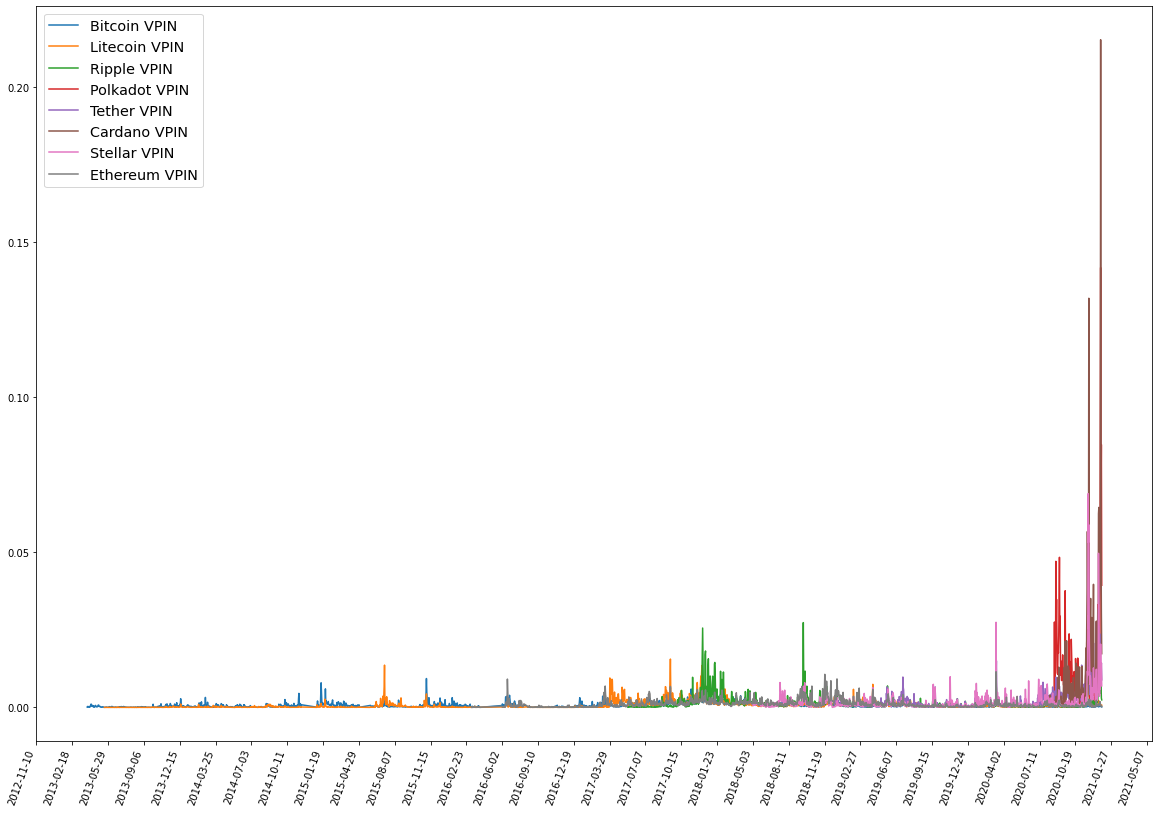

In [9]:
# Plot VPIN through time for top coins
# No datasets present for this plot

fig, ax = plt.subplots(figsize=(20, 15))


plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())

ax.plot(coinDF.date, coinDF.vpin, label='Bitcoin VPIN') 
ax.plot(coinDF2.date, coinDF2.vpin, label='Litecoin VPIN')
ax.plot(coinDF3.date, coinDF3.vpin, label='Ripple VPIN')
ax.plot(coinDF4.date, coinDF4.vpin,  label='Polkadot VPIN')
ax.plot(coinDF5.date, coinDF5.vpin, label='Tether VPIN')
ax.plot(coinDF6.date, coinDF6.vpin, label='Cardano VPIN')
ax.plot(coinDF7.date, coinDF7.vpin, label='Stellar VPIN')
ax.plot(coinDF8.date, coinDF8.vpin, label='Ethereum VPIN')

stepsize=100
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start, end, stepsize))
plt.gcf().
autofmt_xdate()
plt.yticks(fontsize="xx-large")
plt.xticks(rotation=70, fontsize="xx-large")
ax.legend(fontsize="xx-large")
plt.savefig("vpin.jpg")  
plt.show()
plt.close()   

In [5]:
# List of all fully processed files with VPIN and Crashes
# allCoinsCrash.gzip is the top coins parquet file
# allCoinsCrash.gzip is the max possible coins parquet file

# this directory isn't present in the repo so don't re run
os.listdir('/media/alexander/AMR CHAMPER/FInBigData/Crashes/')


['btcusdCrash.csv',
 'adausdCrash.csv',
 'ltcusdCrash.csv',
 'ustusdCrash.csv',
 'xrpusdCrash.csv',
 'dotusdCrash.csv',
 'ethusdCrash.csv',
 'xlmusdCrash.csv',
 'allCoinsCrash.gzip',
 'absusdCrash.csv',
 'agiusdCrash.csv',
 'aiousdCrash.csv',
 'algusdCrash.csv',
 'ampusdCrash.csv',
 'antusdCrash.csv',
 'astusdCrash.csv',
 'atousdCrash.csv',
 'aucusdCrash.csv',
 'avtusdCrash.csv',
 'balusdCrash.csv',
 'batusdCrash.csv',
 'bftusdCrash.csv',
 'bntusdCrash.csv',
 'boxusdCrash.csv',
 'bsvusdCrash.csv',
 'btgusdCrash.csv',
 'bttusdCrash.csv',
 'cbtusdCrash.csv',
 'chzusdCrash.csv',
 'clousdCrash.csv',
 'cndusdCrash.csv',
 'cnnusdCrash.csv',
 'ctxusdCrash.csv',
 'daiusdCrash.csv',
 'datusdCrash.csv',
 'dgbusdCrash.csv',
 'dgxusdCrash.csv',
 'dogusdCrash.csv',
 'drnusdCrash.csv',
 'dshusdCrash.csv',
 'dtausdCrash.csv',
 'dtxusdCrash.csv',
 'edousdCrash.csv',
 'elfusdCrash.csv',
 'enjusdCrash.csv',
 'allCoinsCrashF.gzip',
 'iotjpyusdCrash.csv',
 'iotjpyCrash.csv',
 'ethjpyCrash.csv',
 'eosjpyCr

In [3]:
# These datasets aren't present so don't re-run
# Creating original top coins combined dataset, appended seperately to check mem usage
allCoins = pd.read_csv('/media/alexander/AMR CHAMPER/FInBigData/Crashes/btcusdCrash.csv')
allCoins

,Unnamed: 0,Unnamed: 0.1,time,open,close,high,low,volume,datetime,fltTime,date,change,vpin,isCrash
0,0,0,00:07:00,93.250000,93.3000,93.30,93.250000,93.300000,2013-04-01 00:07:00,7.0,2013-04-01,0.050000,0.000104,0
1,1,1,00:08:00,100.000000,100.0000,100.00,100.000000,93.300000,2013-04-01 00:08:00,8.0,2013-04-01,0.000000,0.000104,1
2,2,2,00:09:00,93.300000,93.3000,93.30,93.300000,33.676862,2013-04-01 00:09:00,9.0,2013-04-01,0.000000,0.000104,1
3,3,3,00:11:00,93.350000,93.4700,93.47,93.350000,20.000000,2013-04-01 00:11:00,11.0,2013-04-01,0.120000,0.000104,0
4,4,4,00:12:00,93.470000,93.4700,93.47,93.470000,2.021627,2013-04-01 00:12:00,12.0,2013-04-01,0.000000,0.000104,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3147684,3147684,3147684,15:05:00,29309.000000,29352.0000,29352.00,29309.000000,1.727491,2021-01-01 15:05:00,1505.0,2021-01-01,43.000000,0.000159,0
3147685,3147685,3147685,15:06:00,29352.478686,29363.6385,29368.00,29352.478686,0.030000,2021-01-01 15:06:00,1506.0,2021-01-01,11.159814,0.000159,0
3147686,3147686,3147686,15:07:00,29367.000000,29357.0000,29367.00,29355.000000,0.412022,2021-01-01 15:07:00,1507.0,2021-01-01,-10.000000,0.000159,0
3147687,3147687,3147687,15:08:00,29357.000000,29367.0000,29367.00,29357.000000,1.671204,2021-01-01 15:08:00,1508.0,2021-01-01,10.000000,0.000159,0


In [4]:
allCoins = allCoins.append(pd.read_csv('/media/alexander/AMR CHAMPER/FInBigData/Crashes/adausdCrash.csv'))
allCoins

,Unnamed: 0,Unnamed: 0.1,time,open,close,high,low,volume,datetime,fltTime,date,change,vpin,isCrash
0,0,0,00:07:00,93.25000,93.30000,93.30000,93.25000,93.300000,2013-04-01 00:07:00,7.0,2013-04-01,0.05000,0.000104,0
1,1,1,00:08:00,100.00000,100.00000,100.00000,100.00000,93.300000,2013-04-01 00:08:00,8.0,2013-04-01,0.00000,0.000104,1
2,2,2,00:09:00,93.30000,93.30000,93.30000,93.30000,33.676862,2013-04-01 00:09:00,9.0,2013-04-01,0.00000,0.000104,1
3,3,3,00:11:00,93.35000,93.47000,93.47000,93.35000,20.000000,2013-04-01 00:11:00,11.0,2013-04-01,0.12000,0.000104,0
4,4,4,00:12:00,93.47000,93.47000,93.47000,93.47000,2.021627,2013-04-01 00:12:00,12.0,2013-04-01,0.00000,0.000104,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46130,46130,46130,15:21:00,0.18278,0.18278,0.18278,0.18278,3375.925287,2021-01-01 15:21:00,1521.0,2021-01-01,0.00000,0.017314,0
46131,46131,46131,15:23:00,0.18290,0.18252,0.18290,0.18252,6073.629452,2021-01-01 15:23:00,1523.0,2021-01-01,-0.00038,0.017314,0
46132,46132,46132,15:24:00,0.18232,0.18232,0.18232,0.18232,72.554462,2021-01-01 15:24:00,1524.0,2021-01-01,0.00000,0.017314,0
46133,46133,46133,15:26:00,0.18253,0.18239,0.18253,0.18239,7600.915000,2021-01-01 15:26:00,1526.0,2021-01-01,-0.00014,0.017314,0


In [5]:
allCoins = allCoins.append(pd.read_csv('/media/alexander/AMR CHAMPER/FInBigData/Crashes/xlmusdCrash.csv'))
allCoins = allCoins.append(pd.read_csv('/media/alexander/AMR CHAMPER/FInBigData/Crashes/ethusdCrash.csv'))

In [7]:
allCoins = allCoins.append(pd.read_csv('/media/alexander/AMR CHAMPER/FInBigData/Crashes/ltcusdCrash.csv'))
allCoins = allCoins.append(pd.read_csv('/media/alexander/AMR CHAMPER/FInBigData/Crashes/ustusdCrash.csv'))


In [8]:
allCoins = allCoins.append(pd.read_csv('/media/alexander/AMR CHAMPER/FInBigData/Crashes/xrpusdCrash.csv'))
allCoins = allCoins.append(pd.read_csv('/media/alexander/AMR CHAMPER/FInBigData/Crashes/dotusdCrash.csv'))

In [11]:
allCoins = allCoins.drop({'Unnamed: 0', 'Unnamed: 0.1'}, axis=1)

In [12]:
# Save top coins
allCoins.to_parquet('/media/alexander/AMR CHAMPER/FInBigData/Crashes/allCoinsCrash.gzip')

In [45]:
# Resuming runable section relying on present data 
# Reading in LTC data for model training
adaCrash = pd.read_csv('testData/adausdCrash.csv')
adaCrash

,Unnamed: 0,time,open,close,high,low,volume,datetime,fltTime,date,change,vpin,isCrash
0,0,10:11:00,0.14270,0.14270,0.14270,0.14270,10.000000,2020-08-06 10:11:00,1011.0,2020-08-06,0.00000,0.002543,0
1,1,10:15:00,0.14251,0.14251,0.14251,0.14251,7557.112400,2020-08-06 10:15:00,1015.0,2020-08-06,0.00000,0.002543,0
2,2,10:16:00,0.14238,0.14238,0.14238,0.14238,7678.994900,2020-08-06 10:16:00,1016.0,2020-08-06,0.00000,0.002543,0
3,3,10:19:00,0.14234,0.14234,0.14234,0.14234,7773.492300,2020-08-06 10:19:00,1019.0,2020-08-06,0.00000,0.002543,0
4,4,10:27:00,0.14241,0.14241,0.14241,0.14241,8118.567000,2020-08-06 10:27:00,1027.0,2020-08-06,0.00000,0.002543,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
46130,46130,15:21:00,0.18278,0.18278,0.18278,0.18278,3375.925287,2021-01-01 15:21:00,1521.0,2021-01-01,0.00000,0.017314,0
46131,46131,15:23:00,0.18290,0.18252,0.18290,0.18252,6073.629452,2021-01-01 15:23:00,1523.0,2021-01-01,-0.00038,0.017314,0
46132,46132,15:24:00,0.18232,0.18232,0.18232,0.18232,72.554462,2021-01-01 15:24:00,1524.0,2021-01-01,0.00000,0.017314,0
46133,46133,15:26:00,0.18253,0.18239,0.18253,0.18239,7600.915000,2021-01-01 15:26:00,1526.0,2021-01-01,-0.00014,0.017314,0


In [3]:
# this dataset isn't present in github repo
# Loading in max coins data for training
allCoins = pd.read_parquet('/media/alexander/AMR CHAMPER/FInBigData/Crashes/allCoinsCrashF.gzip').reset_index().drop('index', axis=1)[{'open', 'close', 'high', 'low', 'volume', 'change', 'fltTime', 'vpin', 'isCrash'}]

In [6]:
# this dataset isn't present in github repo
# loading in ETH pairing data for testing
ethCrash = pd.read_parquet('/media/alexander/AMR CHAMPER/FInBigData/Crashes/ethCrash.gzip').reset_index().drop('index', axis=1)[{'open', 'close', 'high', 'low', 'volume', 'change', 'fltTime', 'vpin', 'isCrash'}]

In [44]:
# Scales data and then seperates into train and test sets
def seperateTarget(coinData):
    coinY = coinData['isCrash']
    
    coinX = coinData[{'open', 'close', 'high', 'low', 'volume', 'change', 'fltTime', 'vpin'}]
    scaler = StandardScaler()
    scaler.fit(coinX)
    scaler.transform(coinX)
    X_train, X_test, y_train, y_test = train_test_split(coinX, coinY, test_size=0.20, random_state=42)
    return X_train, X_test, y_train, y_test

In [46]:

#seperating into train and test sets (notice ethCrash we are overwriting train sets as it 
# was only used for testing)

# X_train, X_test_l, y_train, y_test_l = seperateTarget(ethCrash)
# X_train, X_test, y_train, y_test = seperateTarget(allCoins)
X_train, X_test, y_train, y_test = seperateTarget(adaCrash)

In [47]:
X_train

,volume,close,low,fltTime,vpin,open,change,high
26383,300.000000,0.140000,0.140000,516.0,0.013192,0.140000,0.00000,0.140000
14885,24071.608100,0.106880,0.106800,1840.0,0.004859,0.106800,0.00008,0.106880
43085,36051.138325,0.170320,0.170320,1810.0,0.056494,0.170560,-0.00024,0.170830
14573,501.000000,0.109600,0.109600,1223.0,0.003784,0.109600,0.00000,0.109600
883,1.168502,0.138470,0.138470,2353.0,0.001038,0.138470,0.00000,0.138470
...,...,...,...,...,...,...,...,...
11284,12.951301,0.098155,0.098155,1527.0,0.003750,0.098155,0.00000,0.098155
44732,343.732200,0.178240,0.178190,1016.0,0.056658,0.178190,0.00005,0.178240
38158,3301.856000,0.151430,0.151430,1418.0,0.031568,0.151430,0.00000,0.151430
860,1720.139200,0.139870,0.139870,1246.0,0.001038,0.139870,0.00000,0.139870


In [48]:
# Convert train and test to Dmatrix for speed increase and set params
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)
param = {}
param['objective'] = 'binary:logitraw'
param['eval_metric'] = 'error'
param['tree_method'] = 'gpu_hist'
param['silent'] = 1

In [52]:
# Compare GPU and CPU training speed 
num_round = 1000
print("Training with GPU ...")
tmp = time.time()
gpu_res = {}
xgb.train(param, dtrain, num_round, evals=[(dtest, "test")], 
          evals_result=gpu_res)
gpu_time = time.time() - tmp
print("GPU Training Time: %s seconds" % (str(gpu_time)))

print("Training with CPU ...")
# set tree method back to CPU
param['tree_method'] = 'hist'
tmp = time.time()
cpu_res = {}
xgb.train(param, dtrain, num_round, evals=[(dtest, "test")], 
          evals_result=cpu_res)
cpu_time = time.time() - tmp
print("CPU Training Time: %s seconds" % (str(cpu_time)))

Training with GPU ...
[16:53:56] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	test-error:0.04845
[1]	test-error:0.04736
[2]	test-error:0.04812
[3]	test-error:0.04801
[4]	test-error:0.04790
[5]	test-error:0.04779
[6]	test-error:0.04758
[7]	test-error:0.04725
[8]	test-error:0.04725
[9]	test-error:0.04736
[10]	test-error:0.04736
[11]	test-error:0.04617
[12]	test-error:0.04595
[13]	test-error:0.04573
[14]	test-error:0.04584
[15]	test-error:0.04563
[16]	test-error:0.04563
[17]	test-error:0.04573
[18]	test-error:0.04541
[19]	test-error:0.04541
[20]	test-error:0.04530
[21]	test-error:0.04509
[22]	test-error:0.04498
[23]	test-error:0.04487
[24]	test-error:0.04509
[25]	test-error:0.04509
[26]	test-error:0.04519
[27]	test-erro

[319]	test-error:0.04010
[320]	test-error:0.04032
[321]	test-error:0.04021
[322]	test-error:0.04021
[323]	test-error:0.04021
[324]	test-error:0.04053
[325]	test-error:0.04064
[326]	test-error:0.04043
[327]	test-error:0.04043
[328]	test-error:0.04053
[329]	test-error:0.04043
[330]	test-error:0.04053
[331]	test-error:0.04021
[332]	test-error:0.04021
[333]	test-error:0.04021
[334]	test-error:0.04010
[335]	test-error:0.04010
[336]	test-error:0.04021
[337]	test-error:0.04032
[338]	test-error:0.04032
[339]	test-error:0.04032
[340]	test-error:0.04021
[341]	test-error:0.03999
[342]	test-error:0.03999
[343]	test-error:0.03999
[344]	test-error:0.03999
[345]	test-error:0.03999
[346]	test-error:0.03999
[347]	test-error:0.03988
[348]	test-error:0.03977
[349]	test-error:0.03977
[350]	test-error:0.03988
[351]	test-error:0.03999
[352]	test-error:0.03988
[353]	test-error:0.03967
[354]	test-error:0.03967
[355]	test-error:0.03967
[356]	test-error:0.03967
[357]	test-error:0.03977
[358]	test-error:0.03977


[647]	test-error:0.03988
[648]	test-error:0.03977
[649]	test-error:0.03967
[650]	test-error:0.03956
[651]	test-error:0.03945
[652]	test-error:0.03967
[653]	test-error:0.03967
[654]	test-error:0.03956
[655]	test-error:0.03945
[656]	test-error:0.03945
[657]	test-error:0.03977
[658]	test-error:0.03988
[659]	test-error:0.03934
[660]	test-error:0.03945
[661]	test-error:0.03956
[662]	test-error:0.03956
[663]	test-error:0.03956
[664]	test-error:0.03967
[665]	test-error:0.03988
[666]	test-error:0.03967
[667]	test-error:0.03956
[668]	test-error:0.03956
[669]	test-error:0.03945
[670]	test-error:0.03956
[671]	test-error:0.03934
[672]	test-error:0.03945
[673]	test-error:0.03945
[674]	test-error:0.03934
[675]	test-error:0.03923
[676]	test-error:0.03934
[677]	test-error:0.03945
[678]	test-error:0.03945
[679]	test-error:0.03945
[680]	test-error:0.03956
[681]	test-error:0.03945
[682]	test-error:0.03934
[683]	test-error:0.03934
[684]	test-error:0.03923
[685]	test-error:0.03945
[686]	test-error:0.03945


[975]	test-error:0.03912
[976]	test-error:0.03934
[977]	test-error:0.03912
[978]	test-error:0.03945
[979]	test-error:0.03923
[980]	test-error:0.03934
[981]	test-error:0.03956
[982]	test-error:0.03945
[983]	test-error:0.03923
[984]	test-error:0.03934
[985]	test-error:0.03945
[986]	test-error:0.03956
[987]	test-error:0.03956
[988]	test-error:0.03967
[989]	test-error:0.03956
[990]	test-error:0.03945
[991]	test-error:0.03956
[992]	test-error:0.03967
[993]	test-error:0.03967
[994]	test-error:0.03977
[995]	test-error:0.03977
[996]	test-error:0.03988
[997]	test-error:0.04021
[998]	test-error:0.03999
[999]	test-error:0.03999
GPU Training Time: 16.833214044570923 seconds
Training with CPU ...
[16:54:12] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you f

[292]	test-error:0.03967
[293]	test-error:0.03977
[294]	test-error:0.03999
[295]	test-error:0.04010
[296]	test-error:0.04010
[297]	test-error:0.04021
[298]	test-error:0.04043
[299]	test-error:0.04021
[300]	test-error:0.04010
[301]	test-error:0.04010
[302]	test-error:0.04010
[303]	test-error:0.04010
[304]	test-error:0.03967
[305]	test-error:0.03999
[306]	test-error:0.03967
[307]	test-error:0.03988
[308]	test-error:0.03988
[309]	test-error:0.03977
[310]	test-error:0.03977
[311]	test-error:0.04010
[312]	test-error:0.03977
[313]	test-error:0.03977
[314]	test-error:0.03999
[315]	test-error:0.03999
[316]	test-error:0.03988
[317]	test-error:0.03956
[318]	test-error:0.03945
[319]	test-error:0.03956
[320]	test-error:0.03934
[321]	test-error:0.03945
[322]	test-error:0.03923
[323]	test-error:0.03923
[324]	test-error:0.03912
[325]	test-error:0.03923
[326]	test-error:0.03945
[327]	test-error:0.03945
[328]	test-error:0.03945
[329]	test-error:0.03956
[330]	test-error:0.03956
[331]	test-error:0.03956


[620]	test-error:0.03902
[621]	test-error:0.03902
[622]	test-error:0.03902
[623]	test-error:0.03902
[624]	test-error:0.03902
[625]	test-error:0.03902
[626]	test-error:0.03902
[627]	test-error:0.03902
[628]	test-error:0.03902
[629]	test-error:0.03902
[630]	test-error:0.03902
[631]	test-error:0.03902
[632]	test-error:0.03902
[633]	test-error:0.03902
[634]	test-error:0.03902
[635]	test-error:0.03880
[636]	test-error:0.03880
[637]	test-error:0.03880
[638]	test-error:0.03891
[639]	test-error:0.03891
[640]	test-error:0.03902
[641]	test-error:0.03902
[642]	test-error:0.03902
[643]	test-error:0.03891
[644]	test-error:0.03891
[645]	test-error:0.03891
[646]	test-error:0.03891
[647]	test-error:0.03891
[648]	test-error:0.03891
[649]	test-error:0.03891
[650]	test-error:0.03902
[651]	test-error:0.03912
[652]	test-error:0.03902
[653]	test-error:0.03902
[654]	test-error:0.03880
[655]	test-error:0.03880
[656]	test-error:0.03880
[657]	test-error:0.03880
[658]	test-error:0.03858
[659]	test-error:0.03858


[948]	test-error:0.03923
[949]	test-error:0.03902
[950]	test-error:0.03891
[951]	test-error:0.03891
[952]	test-error:0.03891
[953]	test-error:0.03880
[954]	test-error:0.03891
[955]	test-error:0.03891
[956]	test-error:0.03891
[957]	test-error:0.03902
[958]	test-error:0.03912
[959]	test-error:0.03923
[960]	test-error:0.03934
[961]	test-error:0.03923
[962]	test-error:0.03902
[963]	test-error:0.03912
[964]	test-error:0.03902
[965]	test-error:0.03923
[966]	test-error:0.03912
[967]	test-error:0.03912
[968]	test-error:0.03912
[969]	test-error:0.03912
[970]	test-error:0.03912
[971]	test-error:0.03902
[972]	test-error:0.03891
[973]	test-error:0.03891
[974]	test-error:0.03880
[975]	test-error:0.03912
[976]	test-error:0.03912
[977]	test-error:0.03912
[978]	test-error:0.03912
[979]	test-error:0.03912
[980]	test-error:0.03912
[981]	test-error:0.03912
[982]	test-error:0.03912
[983]	test-error:0.03912
[984]	test-error:0.03912
[985]	test-error:0.03902
[986]	test-error:0.03880
[987]	test-error:0.03869


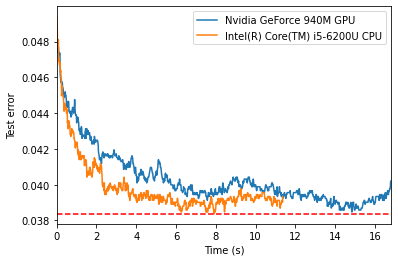

In [53]:
# Plot runtime difference between CPU and GPU

# Note on this plot: the speed up with GPU comes from running large datasets, and passing 
# data between memory and the GPU is actually slower than between mem and CPU. 
# As a result, on smaller datasets the GPU is slower, while on larger it is much more
# quick

min_error = min(min(gpu_res['test'][param['eval_metric']]), min(cpu_res['test'][param['eval_metric']]))
gpu_iteration_time = [x / (num_round * 1.0) * gpu_time for x in range(0, num_round)]
cpu_iteration_time = [x / (num_round * 1.0) * cpu_time for x in range(0, num_round)]
plt.plot(gpu_iteration_time, gpu_res['test'][param['eval_metric']], label='Nvidia GeForce 940M GPU')
plt.plot(cpu_iteration_time, cpu_res['test'][param['eval_metric']], label='Intel(R) Core(TM) i5-6200U CPU')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Test error')
plt.axhline(y=min_error, color='r', linestyle='dashed')
plt.margins(x=0)
#plt.ylim((0.23, 0.35))
plt.show()

In [54]:
# Actually used for analysis training cell running on GPU
num_round = 1000
tmp = time.time()
total_res = {}
modelFull = xgb.train(param, dtrain, num_round, evals=[(dtest, "test")], 
          evals_result=total_res)
total_time = time.time() - tmp
print("Total Training Time: %s seconds" % (str(total_time)))

[16:56:06] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	test-error:0.04942
[1]	test-error:0.04931
[2]	test-error:0.04888
[3]	test-error:0.04888
[4]	test-error:0.04779
[5]	test-error:0.04801
[6]	test-error:0.04779
[7]	test-error:0.04769
[8]	test-error:0.04812
[9]	test-error:0.04693
[10]	test-error:0.04704
[11]	test-error:0.04693
[12]	test-error:0.04682
[13]	test-error:0.04671
[14]	test-error:0.04682
[15]	test-error:0.04671
[16]	test-error:0.04682
[17]	test-error:0.04628
[18]	test-error:0.04639
[19]	test-error:0.04617
[20]	test-error:0.04595
[21]	test-error:0.04595
[22]	test-error:0.04498
[23]	test-error:0.04519
[24]	test-error:0.04552
[25]	test-error:0.04541
[26]	test-error:0.04498
[27]	test-error:0.04498
[28]	test-er

[320]	test-error:0.03934
[321]	test-error:0.03945
[322]	test-error:0.03923
[323]	test-error:0.03923
[324]	test-error:0.03912
[325]	test-error:0.03923
[326]	test-error:0.03945
[327]	test-error:0.03945
[328]	test-error:0.03945
[329]	test-error:0.03956
[330]	test-error:0.03956
[331]	test-error:0.03956
[332]	test-error:0.03956
[333]	test-error:0.03956
[334]	test-error:0.03967
[335]	test-error:0.03967
[336]	test-error:0.03977
[337]	test-error:0.03977
[338]	test-error:0.03956
[339]	test-error:0.03945
[340]	test-error:0.03945
[341]	test-error:0.03945
[342]	test-error:0.03934
[343]	test-error:0.03934
[344]	test-error:0.03934
[345]	test-error:0.03945
[346]	test-error:0.03945
[347]	test-error:0.03934
[348]	test-error:0.03934
[349]	test-error:0.03923
[350]	test-error:0.03945
[351]	test-error:0.03934
[352]	test-error:0.03912
[353]	test-error:0.03912
[354]	test-error:0.03902
[355]	test-error:0.03902
[356]	test-error:0.03902
[357]	test-error:0.03912
[358]	test-error:0.03912
[359]	test-error:0.03923


[648]	test-error:0.03891
[649]	test-error:0.03891
[650]	test-error:0.03902
[651]	test-error:0.03912
[652]	test-error:0.03902
[653]	test-error:0.03902
[654]	test-error:0.03880
[655]	test-error:0.03880
[656]	test-error:0.03880
[657]	test-error:0.03880
[658]	test-error:0.03858
[659]	test-error:0.03858
[660]	test-error:0.03847
[661]	test-error:0.03847
[662]	test-error:0.03858
[663]	test-error:0.03869
[664]	test-error:0.03858
[665]	test-error:0.03847
[666]	test-error:0.03847
[667]	test-error:0.03847
[668]	test-error:0.03847
[669]	test-error:0.03858
[670]	test-error:0.03869
[671]	test-error:0.03869
[672]	test-error:0.03880
[673]	test-error:0.03869
[674]	test-error:0.03869
[675]	test-error:0.03891
[676]	test-error:0.03869
[677]	test-error:0.03891
[678]	test-error:0.03902
[679]	test-error:0.03902
[680]	test-error:0.03891
[681]	test-error:0.03923
[682]	test-error:0.03934
[683]	test-error:0.03923
[684]	test-error:0.03923
[685]	test-error:0.03923
[686]	test-error:0.03923
[687]	test-error:0.03891


[976]	test-error:0.03912
[977]	test-error:0.03912
[978]	test-error:0.03912
[979]	test-error:0.03912
[980]	test-error:0.03912
[981]	test-error:0.03912
[982]	test-error:0.03912
[983]	test-error:0.03912
[984]	test-error:0.03912
[985]	test-error:0.03902
[986]	test-error:0.03880
[987]	test-error:0.03869
[988]	test-error:0.03869
[989]	test-error:0.03880
[990]	test-error:0.03891
[991]	test-error:0.03891
[992]	test-error:0.03891
[993]	test-error:0.03902
[994]	test-error:0.03902
[995]	test-error:0.03912
[996]	test-error:0.03912
[997]	test-error:0.03912
[998]	test-error:0.03902
[999]	test-error:0.03934
Total Training Time: 15.245841264724731 seconds


In [74]:
# Save the error tape after training for use in plotting
pd.DataFrame(total_res).to_csv('errorTapes/demoError.csv')


In [75]:
# Save model for future usage
pickle.dump(modelFull, open("models/demoModel.pickle.dat", "wb"))

In [76]:
# Loading models
loaded_model = pickle.load(open("models/demoModel.pickle.dat", "rb"))
loaded_model_full = pickle.load(open("models/fullModel.pickle.dat", "rb"))

In [77]:
#predictions for loaded model
loaded_model.predict(dtest)


array([ -6.9313493,  -9.400835 , -11.9687805, ...,  -3.726279 ,
       -10.702378 ,  -8.491743 ], dtype=float32)

In [73]:
# Loading error tapes for plotting

#ltcError = pd.read_csv('ltcErrorTape.csv')
fullError = pd.read_csv('errorTapes/allCoinsPlusErrorTape.csv')
fullErrorjpy = pd.read_csv('errorTapes/allCoinsPlusJpyErrorTape.csv')
fullErroreth = pd.read_csv('errorTapes/allCoinsPlusEthErrorTape.csv')

In [63]:
# Manual destring 

#ltcError = ltcError['test'][0].strip('][').split(', ') 
#ltcError = [float(ele) for ele in ltcError]

fullError = fullError['test'][0].strip('][').split(', ') 
fullError = [float(ele) for ele in fullError]

fullErrorjpy = fullErrorjpy['test'][0].strip('][').split(', ') 
fullErrorjpy = [float(ele) for ele in fullErrorjpy]

fullErroreth = fullErroreth['test'][0].strip('][').split(', ') 
fullErroreth = [float(ele) for ele in fullErroreth]


In [64]:
# List form error tape 
fullError

[0.058034,
 0.058137,
 0.058115,
 0.05807,
 0.058188,
 0.058053,
 0.057919,
 0.057897,
 0.057744,
 0.0577,
 0.057503,
 0.057367,
 0.057157,
 0.057096,
 0.056973,
 0.05692,
 0.056793,
 0.056671,
 0.056459,
 0.056409,
 0.056376,
 0.056268,
 0.056123,
 0.056073,
 0.055922,
 0.055859,
 0.055815,
 0.055819,
 0.055739,
 0.055664,
 0.055573,
 0.055538,
 0.055483,
 0.055436,
 0.055382,
 0.055372,
 0.055348,
 0.055338,
 0.055323,
 0.055301,
 0.055231,
 0.055183,
 0.055179,
 0.055171,
 0.055161,
 0.055111,
 0.055081,
 0.055068,
 0.05507,
 0.055047,
 0.055036,
 0.05502,
 0.055011,
 0.054982,
 0.054983,
 0.054977,
 0.054958,
 0.054954,
 0.054956,
 0.054934,
 0.054914,
 0.054907,
 0.054901,
 0.0549,
 0.054889,
 0.054885,
 0.054888,
 0.054883,
 0.054861,
 0.054831,
 0.054806,
 0.054795,
 0.054788,
 0.054758,
 0.054755,
 0.054754,
 0.054751,
 0.054736,
 0.054738,
 0.054734,
 0.054745,
 0.05474,
 0.054713,
 0.054705,
 0.054674,
 0.054654,
 0.054651,
 0.054645,
 0.054637,
 0.054638,
 0.054627,
 0.05460

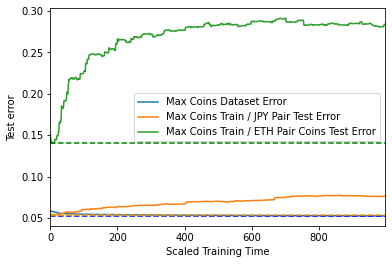

In [65]:
# Plot various training errors for comparison
num_round=1000
total_time = 1000
min_error = min(fullError)
#min_error_ltc = min(ltcError)
min_error_fl = min(fullErrorjpy)
min_error_lf = min(fullErroreth)
gpu_iteration_time = [x / (num_round * 1.0) * total_time for x in range(0, num_round)]

plt.plot(gpu_iteration_time, fullError, label='Max Coins Dataset Error')
plt.plot(gpu_iteration_time, fullErrorjpy, label='Max Coins Train / JPY Pair Test Error')
plt.plot(gpu_iteration_time, fullErroreth, label='Max Coins Train / ETH Pair Coins Test Error')
plt.legend()
plt.xlabel('Scaled Training Time')
plt.ylabel('Test error')
plt.axhline(y=min_error, color='b', linestyle='dashed')
#plt.axhline(y=min_error_ltc, color='orange', linestyle='dashed')
plt.axhline(y=min_error_fl, color='orange', linestyle='dashed')
plt.axhline(y=min_error_lf, color='green', linestyle='dashed')
plt.margins(x=0)
#plt.ylim((0.23, 0.35))
plt.show()

<Figure size 1152x864 with 0 Axes>

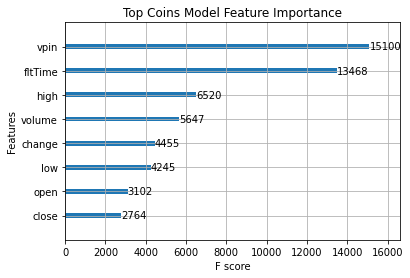

In [68]:
# Feature importance plot
plt.figure(figsize=(16, 12))
xgb.plot_importance(loaded_model_full)
plt.title('Top Coins Model Feature Importance')
plt.show()

In [27]:
# Just combining ETH pairing frames into a singular dataset

# This dataset isn't present
eth = pd.read_csv('/media/alexander/AMR CHAMPER/FInBigData/Crashes/iotethCrash.csv').reset_index().drop('index', axis=1)[{'open', 'close', 'high', 'low', 'volume', 'change', 'fltTime', 'vpin', 'isCrash'}]
eth

,isCrash,volume,change,close,low,fltTime,vpin,open,high
0,0,0.001100,0.000000,0.001260,0.001260,1259.0,0.002865,0.001260,0.001260
1,0,0.001100,0.000000,0.001260,0.001260,1301.0,0.002865,0.001260,0.001260
2,1,68184.614850,0.000038,0.001288,0.001250,1339.0,0.002865,0.001250,0.001288
3,0,19555.361220,0.000000,0.001288,0.001288,1340.0,0.002865,0.001288,0.001288
4,0,14092.935651,0.000002,0.001290,0.001288,1341.0,0.002865,0.001288,0.001290
...,...,...,...,...,...,...,...,...,...
340414,0,8.550421,0.000000,0.000408,0.000408,1440.0,0.000030,0.000408,0.000408
340415,0,8.599444,0.000000,0.000406,0.000406,1441.0,0.000030,0.000406,0.000406
340416,0,8.593069,0.000000,0.000407,0.000407,1451.0,0.000030,0.000407,0.000407
340417,0,18.018946,-0.000001,0.000406,0.000406,1459.0,0.000030,0.000407,0.000407


In [29]:
# datasets not present
eth = eth.append(pd.read_csv('/media/alexander/AMR CHAMPER/FInBigData/Crashes/etpethCrash.csv').reset_index().drop('index', axis=1)[{'open', 'close', 'high', 'low', 'volume', 'change', 'fltTime', 'vpin', 'isCrash'}])
eth

,isCrash,volume,change,close,low,fltTime,vpin,open,high
0,0,0.001100,0.000000e+00,0.001260,0.001260,1259.0,0.002865,0.001260,0.001260
1,0,0.001100,0.000000e+00,0.001260,0.001260,1301.0,0.002865,0.001260,0.001260
2,1,68184.614850,3.810000e-05,0.001288,0.001250,1339.0,0.002865,0.001250,0.001288
3,0,19555.361220,0.000000e+00,0.001288,0.001288,1340.0,0.002865,0.001288,0.001288
4,0,14092.935651,1.900000e-06,0.001290,0.001288,1341.0,0.002865,0.001288,0.001290
...,...,...,...,...,...,...,...,...,...
71880,0,15.122899,0.000000e+00,0.000113,0.000113,537.0,0.000024,0.000113,0.000113
71881,1,300.000000,0.000000e+00,0.000117,0.000117,909.0,0.000024,0.000117,0.000117
71882,0,190.000000,9.000000e-07,0.000118,0.000117,910.0,0.000024,0.000117,0.000118
71883,0,70.000000,1.000000e-08,0.000118,0.000118,911.0,0.000024,0.000118,0.000118


In [30]:
# no dataset
eth.to_parquet('/media/alexander/AMR CHAMPER/FInBigData/Crashes/ethCrash.gzip')

In [1]:
# Load allCoins for testing correlation between columns
# dataset not present
allCoins = pd.read_parquet('/media/alexander/AMR CHAMPER/FInBigData/Crashes/allCoinsCrashF.gzip').reset_index().drop('index', axis=1)[{'open', 'close', 'high', 'low', 'volume', 'change', 'fltTime', 'vpin', 'isCrash'}]

In /home/alexander/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/alexander/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/alexander/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/alexander/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/alexander/.local/lib/python3.6/site-packages/matplo

In [2]:
# Intra column Correlation 
# dataset not present
allCoins.corr()

,fltTime,low,high,volume,isCrash,open,vpin,close,change
fltTime,1.000000,0.000080,0.000187,0.003718,0.009209,0.000080,0.002781,0.000187,0.000185
low,0.000080,1.000000,0.707143,-0.000494,0.000042,1.000000,-0.001058,0.707143,-0.000002
high,0.000187,0.707143,1.000000,-0.000365,0.000823,0.707143,-0.000661,1.000000,0.707069
volume,0.003718,-0.000494,-0.000365,1.000000,0.070288,-0.000494,0.042231,-0.000365,-0.000021
isCrash,0.009209,0.000042,0.000823,0.070288,1.000000,0.000042,0.153934,0.000823,0.001121
open,0.000080,1.000000,0.707143,-0.000494,0.000042,1.000000,-0.001058,0.707143,-0.000002
vpin,0.002781,-0.001058,-0.000661,0.042231,0.153934,-0.001058,1.000000,-0.000661,0.000124
close,0.000187,0.707143,1.000000,-0.000365,0.000823,0.707143,-0.000661,1.000000,0.707069
change,0.000185,-0.000002,0.707069,-0.000021,0.001121,-0.000002,0.000124,0.707069,1.000000


In [72]:
ada = pd.read_parquet('testData/adausdCrash.gzip').reset_index().drop('index', axis=1)[{'open', 'close', 'high', 'low', 'volume', 'change', 'fltTime', 'vpin', 'isCrash'}]
ada.corr()

,volume,close,low,fltTime,vpin,isCrash,open,change,high
volume,1.000000,0.073424,0.071894,-0.005846,0.174717,0.094771,0.074099,-0.090154,0.075365
close,0.073424,1.000000,0.999986,-0.003949,0.480285,0.099655,0.999970,-0.035353,0.999981
low,0.071894,0.999986,1.000000,-0.003891,0.479521,0.098682,0.999980,-0.038430,0.999967
fltTime,-0.005846,-0.003949,-0.003891,1.000000,-0.006041,-0.013036,-0.003901,-0.006030,-0.003979
vpin,0.174717,0.480285,0.479521,-0.006041,1.000000,0.196114,0.480452,-0.040345,0.481178
isCrash,0.094771,0.099655,0.098682,-0.013036,0.196114,1.000000,0.099863,-0.030760,0.100806
open,0.074099,0.999970,0.999980,-0.003901,0.480452,0.099863,1.000000,-0.043076,0.999987
change,-0.090154,-0.035353,-0.038430,-0.006030,-0.040345,-0.030760,-0.043076,1.000000,-0.039923
high,0.075365,0.999981,0.999967,-0.003979,0.481178,0.100806,0.999987,-0.039923,1.000000
